In [47]:
!pip install pyldavis

In [48]:
!pip install --upgrade numpy


  Using cached numpy-2.2.5-cp311-cp311-win_amd64.whl.metadata (60 kB)
Using cached numpy-2.2.5-cp311-cp311-win_amd64.whl (12.9 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.2.5 which is incompatible.
scipy 1.10.1 requires numpy<1.27.0,>=1.19.5, but you have numpy 2.2.5 which is incompatible.


In [49]:
!pip install --upgrade gensim

  Using cached numpy-1.26.4-cp311-cp311-win_amd64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-win_amd64.whl (15.8 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.5
    Uninstalling numpy-2.2.5:
      Successfully uninstalled numpy-2.2.5


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [73]:
import nltk
nltk.download('stopwords')

import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.phrases import Phrases, Phraser

# spacy for lemmatization
import spacy
from spacy.cli.download import download
download(model="en_core_web_sm")

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [51]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'jaki_application', 'raya', 'semester', 'jajar', 'ojol',
                   'agam', 'waeg', 'gbk', 'spo', 'sajete', 'opponentcovid', 'twilight', 'didi', 'taufik', 'pile', 'tessleri'])

In [52]:
# Import Dataset
df = pd.DataFrame(pd.read_csv("Tweets_airlines_clean_text.csv", sep = ",", header = 0, index_col = False))
df.to_json("Tweets_airlines_clean_text.json", orient = "records", date_format = "epoch", double_precision = 10, force_ascii = True, date_unit = "ms", default_handler = None)
df = pd.read_json('Tweets_airlines_clean_text.json')
df

,airline_sentiment,clean_text,airline
0,positive,plus youve added commercials experience tacky,Virgin America
1,negative,really aggressive blast obnoxious entertainmen...,Virgin America
2,negative,really big bad thing,Virgin America
3,negative,seriously would pay flight seats didnt playing...,Virgin America
4,positive,yes nearly every time fly vx ear worm wont go ...,Virgin America
...,...,...,...
11536,negative,flight cancelled flightled leaving tomorrow mo...,American
11537,negative,right cue delays,American
11538,positive,thank got different flight chicago,American
11539,negative,leaving minutes late flight warnings communica...,American


In [53]:
# Convert to list
data = df.clean_text.values.tolist()

data = [re.sub('\S*@\S*\s?', '', sent or '') for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

print(data[:1])

['plus youve added commercials experience tacky']


In [54]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['plus', 'youve', 'added', 'commercials', 'experience', 'tacky']]


In [55]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['plus', 'youve', 'added', 'commercials', 'experience', 'tacky']


In [56]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [57]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

In [58]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['ve', 'add', 'commercial', 'experience', 'tacky']]


In [59]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)]]


In [60]:
id2word[0]

'add'

In [61]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('add', 1), ('commercial', 1), ('experience', 1), ('tacky', 1), ('ve', 1)]]

In [62]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [63]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.140*"flight" + 0.076*"get" + 0.054*"call" + 0.052*"cancel" + 0.036*"help" '
  '+ 0.025*"wait" + 0.025*"flightle" + 0.021*"phone" + 0.021*"try" + '
  '0.020*"need"'),
 (1,
  '0.081*"hour" + 0.041*"delay" + 0.040*"plane" + 0.037*"make" + 0.027*"take" '
  '+ 0.023*"guy" + 0.021*"sit" + 0.020*"gate" + 0.018*"way" + 0.018*"crew"'),
 (2,
  '0.037*"time" + 0.032*"go" + 0.032*"m" + 0.031*"ve" + 0.031*"still" + '
  '0.031*"bag" + 0.027*"tell" + 0.021*"work" + 0.019*"seat" + 0.019*"aa"'),
 (3,
  '0.053*"thank" + 0.045*"customer" + 0.042*"service" + 0.039*"hold" + '
  '0.027*"day" + 0.023*"s" + 0.022*"bad" + 0.020*"say" + 0.017*"airline" + '
  '0.017*"fly"'),
 (4,
  '0.042*"weather" + 0.033*"ticket" + 0.033*"luggage" + 0.032*"miss" + '
  '0.031*"reservation" + 0.030*"number" + 0.018*"morning" + 0.018*"experience" '
  '+ 0.017*"find" + 0.015*"think"')]


In [64]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.421881470882158

Coherence Score:  0.2843700364164844


In [65]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.389790 -0.022214       1        1  29.045827
3     -0.126375 -0.307394       2        1  23.928001
2     -0.092023  0.268082       3        1  19.909213
1     -0.095583  0.043187       4        1  16.810556
4     -0.075809  0.018339       5        1  10.306403, topic_info=                 Term         Freq        Total Category  logprob  loglift
18             flight  3567.000000  3567.000000  Default  30.0000  30.0000
117               get  1926.000000  1926.000000  Default  29.0000  29.0000
36               hour  1189.000000  1189.000000  Default  28.0000  28.0000
99               call  1371.000000  1371.000000  Default  27.0000  27.0000
228            cancel  1324.000000  1324.000000  Default  26.0000  26.0000
...               ...          ...          ...      ...      ...      ...
407              mean    64.728925    65.479030   Topic5  -4.9386   2.2609
165              hard    64.066182    64.822661   Topic5  -4.9489   2.2607
65                lax    57.032352    57.796618   Topic5  -5.0652   2.2591
1045             mile    54.470875    55.212742   Topic5  -5.1111   2.2589
124   booking_problem    54.530261    55.282021   Topic5  -5.1100   2.2587

[182 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
3047      3  0.997650       aa
432       1  0.999199    agent
115       5  0.988892      air
153       2  0.996651  airline
446       3  0.997127  airport
...     ...       ...      ...
379       5  0.997764  weather
251       3  0.993657  website
43        2  0.997422     well
157       3  0.999306     work
50        3  0.994307      yet

[153 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 3, 2, 5])

In [66]:
def compute_coherence_values(dictionary, corpus, texts, num_topics, start=1, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, num_topics, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [67]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=1, num_topics=5, step=1)

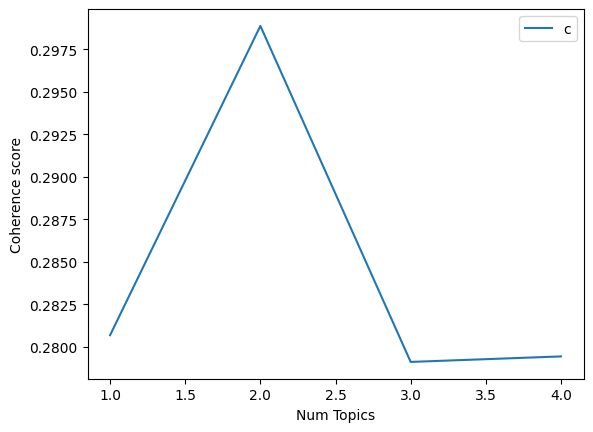

In [68]:
# Show graph
num_topics=5; start=1; step=1;
x = range(start, num_topics, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()# Print the coherence scores

In [69]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 5))

Num Topics = 1  has Coherence Value of 0.28068619
Num Topics = 2  has Coherence Value of 0.29888517
Num Topics = 3  has Coherence Value of 0.27911351
Num Topics = 4  has Coherence Value of 0.27943722


In [77]:
results = {}
for airline in df['airline'].unique():
    print(f"\n=== Processing: {airline} ===")
    airline_df = df[df['airline'] == airline]
    data = airline_df['clean_text'].dropna().tolist()
    data_words = list(sent_to_words(data))

    # Create bigrams
    bigram = Phrases(data_words, min_count=5, threshold=100)
    bigram_mod = Phraser(bigram)


=== Processing: Virgin America ===

=== Processing: United ===

=== Processing: Southwest ===

=== Processing: Delta ===

=== Processing: US Airways ===

=== Processing: American ===


In [78]:
# Preprocess
    data_nostop = remove_stopwords(data_words)
    data_bigrams = make_bigrams(data_nostop, bigram_mod)
    data_lemmatized = lemmatization(data_bigrams)

IndentationError: unexpected indent (3187771929.py, line 2)

In [79]:
# Dictionary and Corpus
    id2word = corpora.Dictionary(data_lemmatized)
    corpus = [id2word.doc2bow(text) for text in data_lemmatized]

IndentationError: unexpected indent (3768958625.py, line 2)

In [80]:
# LDA Model
    lda_model = LdaModel(corpus=corpus,
                         id2word=id2word,
                         num_topics=4,
                         random_state=100,
                         update_every=1,
                         chunksize=100,
                         passes=10,
                         alpha='auto',
                         per_word_topics=True)

IndentationError: unexpected indent (3804308481.py, line 2)

In [81]:
# Coherence
coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()

In [82]:
# Coherence score
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print(f"Coherence Score: {coherence_lda:.4f}")
    print("Topik-topik:")
    for idx, topic in lda_model.print_topics():
        print(f" - Topic {idx}: {topic}")

IndentationError: unexpected indent (2402074204.py, line 2)

In [ ]:
    # Simpan hasil
    results[airline] = {
        "model": lda_model,
        "corpus": corpus,
        "dictionary": id2word,
        "texts": data_lemmatized,
        "coherence": coherence_lda
    }


In [ ]:
 # Visualisasi (jika kamu mau tampilkan)
    vis = gensimvis.prepare(lda_model, corpus, id2word)
    pyLDAvis.display(vis)

https://medium.com/@listari.tari/topic-modeling-menggunakan-latent-dirchlect-allocation-part-2-topic-modeling-with-gensim-c9ffd196cb87